# IDL PROJECT: STUDY OF  ACCURACY IN TERMS OF WEIGHT INITIALIZATION AND BATCH SIZE
The aim of this notebook is to study how the **weight initialization** and **batch size** of a network affects its performance. Accuracy is used as a measure of performance.

The data source used is the **MNIST** database, a collection of 60.000 images of handwritten digits from 0 to 9.

  
Initialization is reallly important, here we study and compare all the initializations that pytorch give in his library and we compare them to see which of them are better or worse. It is really important to initialize well the values because that has an strong impact to the learning of the neural network.

Regarding the batch size, in general terms, the larger the batch size is, the quicker the model will complete each epoch during training. This is because the computational resources of the machine, it may be able to process much more than one single sample at a time. The point is, however, even if our machine can handle very large batches, the quality of the model may degrade and this will cause the model not to generalize well on data it has not seen before.

## Package installation
 Install Python Imaging Library (Fork)
 
 Install MatLab Plotting Library
 
 Instal scikit
 
 Install pytorch
 
 Install  torchvision ()package consists of popular datasets, model architectures, and common image transformations for computer vision.)

In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 2.0MB 12.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


## Imports

In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Define the neural network object
Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from torch.nn.Module.

In its __init__ method, we create the layers we are going to need and store them as member variables.

In its forward method we implement the forward pass computation, making use of the layers we created in the constructor.

2x  2D convolutional layers

2x Linear layers

LINKS:

[ReLU](https://pytorch.org/docs/stable/nn.html#relu)

[2D Convolution](https://pytorch.org/docs/stable/nn.html#conv2d)

[MAX POOLING 2D](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/max_pool2d)

[LINEAR](https://pytorch.org/docs/stable/nn.html#linear)



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Testing Weigths initialization

## Function to train over an epoch
Now let's create a function that trains over an epoch. Every N steps we will print the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the negative log likelihood (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

## Function to evaluate performance
And now let's create a similar function but to evaluate the performance of the model over a validation data set:


In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

## Load MNIST and normalize the data
Now, we will use the dataset from torchvision to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

Note that we apply a linear transformation to normalize the data.

In [0]:
num_epochs = 10#Moved here to make it a global variable
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

## Functions to initialize the weights according to various methods

Definition of the weight initialization function for every possible initialization available in nn.init.

DISCLAIMER: eye_ and kaiming_orthogonal_ were resulting in many troubles and have been subsitituted by ones_ (this was done for the sake of simplicity and avoid changing a big part of the code).

In [0]:
#Dictionary containing the keys and values of the initialization functions
weight_init_dict = {
    "0" : "init_weights_xavier_uniform",
    "1" : "init_weights_xavier_normal",
    "2" : "init_weights_uniform",
    "3" : "init_weights_normal",
    "4" : "init_weights_zeros",
    "5" : "init_weights_ones",
    #"6" : "init_weights_eye",
    "6" : "init_weights_ones",
    "7" : "init_weights_constant",
    "8" : "init_weights_kaiming_uniform",
    "9" : "init_weights_kaiming_normal",
    #"10" : "init_weights_kaiming_orthogonal",
    "10" : "init_weights_ones",
}

def init_weights_xavier_uniform(m):
  if type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.xavier_uniform_(m.weight)
    
def init_weights_xavier_normal(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.xavier_normal_(m.weight)
  
def init_weights_uniform(m):
  if type(m) == nn.Linear:
    nn.init.uniform_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.uniform_(m.weight)
    
#By default mean = 0 and stdd = 1.
def init_weights_normal(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.normal_(m.weight)
    
def init_weights_zeros(m):
  if type(m) == nn.Linear:
    nn.init.zeros_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.zeros_(m.weight)
    
def init_weights_ones(m):
  if type(m) == nn.Linear:
    nn.init.ones_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.ones_(m.weight)
    
def init_weights_eye(m):
  #init_weights_ones copies to avoid changing the code. See nn.init.eye_
  if type(m) == nn.Linear:
    nn.init.ones_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.ones_(m.weight)
    
def init_weights_constant(m):
  if type(m) == nn.Linear:
    nn.init.constant_(m.weight,0.14)#Constant chosen at random by us.
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.constant_(m.weight,0.14)#Constant chosen at random by us.
    
def init_weights_kaiming_uniform(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_uniform_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.kaiming_uniform_(m.weight)
    
def init_weights_kaiming_normal(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.kaiming_normal_(m.weight)
    
def init_weights_kaiming_orthogonal(m):
  #init_weights_ones copies to avoid changing the code. See nn.init.orthogonal
  if type(m) == nn.Linear:
    nn.init.ones_(m.weight)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.ones_(m.weight)

## Function which trains the network with a given weight initialization.

Let's create a function which given a integer included in [0,10] , creates the network with the corresponding weight initialization, moves it to the GPU and iterates through some epochs of training:


In [0]:
def train_with_init(weight_init):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #IMPORTANT NOTE: the model has to be reinstantiated for every weight 
  #initialization in order to forget the learning (good or bad) of a previously 
  #executed initialization.
  model = Net().to(device)
  if weight_init == "0":
    model.apply(init_weights_xavier_uniform)
  elif weight_init == "1":
    model.apply(init_weights_xavier_normal)
  elif weight_init == "2":
    model.apply(init_weights_uniform)
  elif weight_init == "3":
    model.apply(init_weights_normal)
  elif weight_init =="4":
    model.apply(init_weights_zeros)
  elif weight_init == "5":
    model.apply(init_weights_ones)
  elif weight_init == "6":
    model.apply(init_weights_eye)
  elif weight_init == "7":
    model.apply(init_weights_constant)
  elif weight_init == "8":
    model.apply(init_weights_kaiming_uniform)
  elif weight_init == "9":
    model.apply(init_weights_kaiming_normal)
  elif weight_init == "10":
    model.apply(init_weights_kaiming_orthogonal)
    
  #SGD optimizer with momentum
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  train_losses = []
  valid_losses = []
  valid_x = []
  
  #Because of modifications to the code to plot the grphs, num_epochs has to be
  #a global variable. It has been declared outside a function in another cell.
  #num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      valid_loss = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  #print(len(train_losses)) is 4690
  #print(len(valid_losses)) is num_epochs
  
  #RETURN A TUPLE containing the arrays which are required for the plots.
  lossesTV = (train_losses,valid_losses,valid_x)
  return lossesTV
 
  

## Execution

Finally, execute *train_with_init* for every specified weight initialization.

**************INITIALIZATION IS: init_weights_xavier_uniform **************
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.408953
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.334257
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.214319
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.339509
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.133454
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.143425

Validation set: Average loss: 0.1274, Accuracy: 9633/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.122801
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.147589
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.146138
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.076795
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.101481
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.068176

Validation set: Average loss: 0.0733, Accuracy: 9777/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.091960
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.101110
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.038479
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.128879
Train

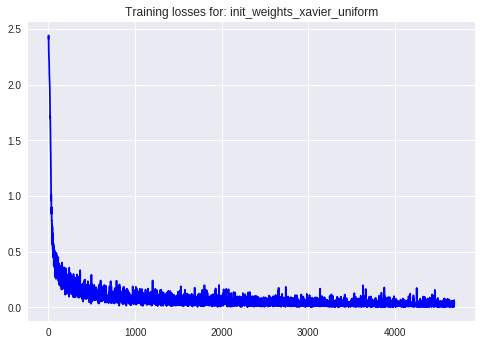

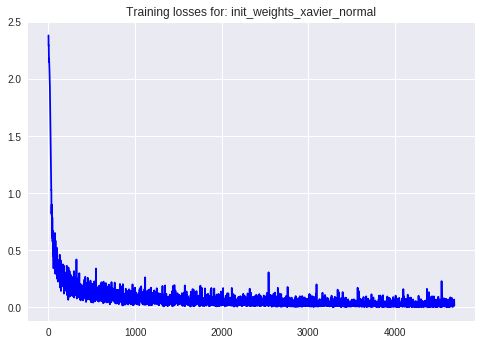

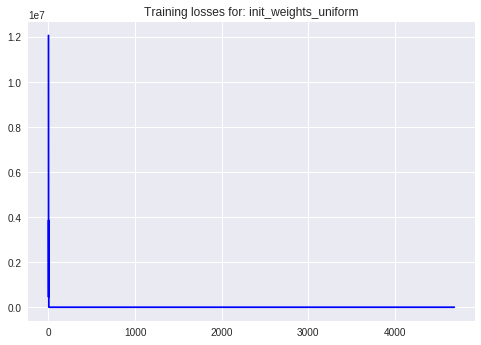

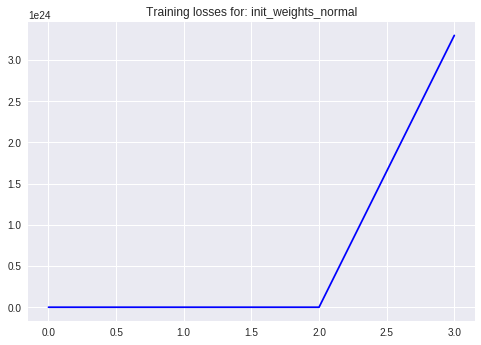

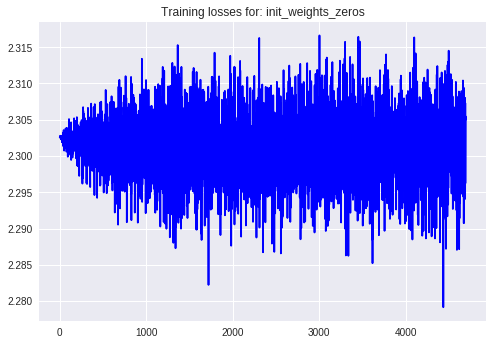

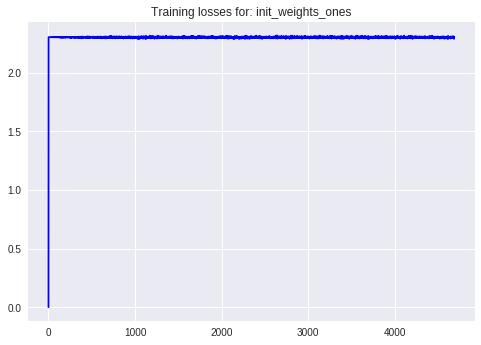

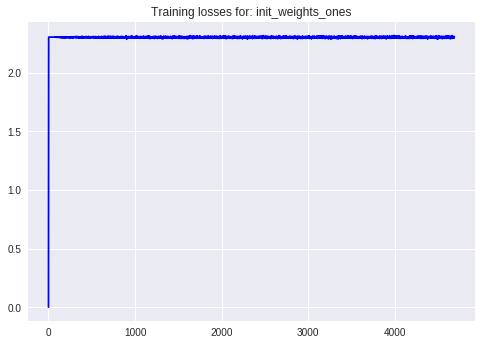

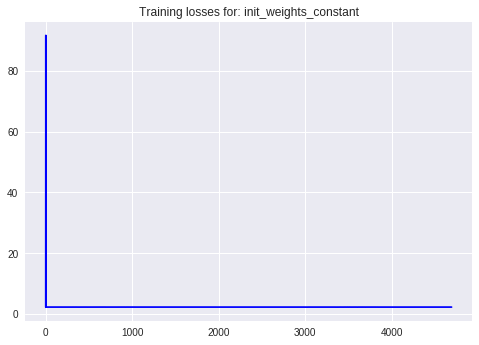

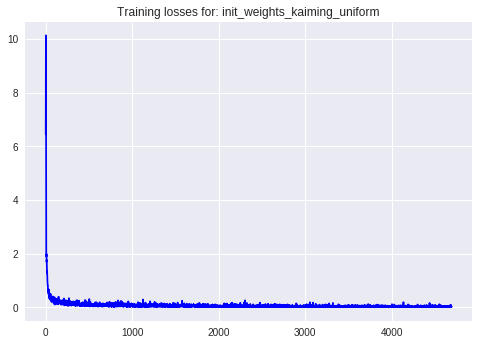

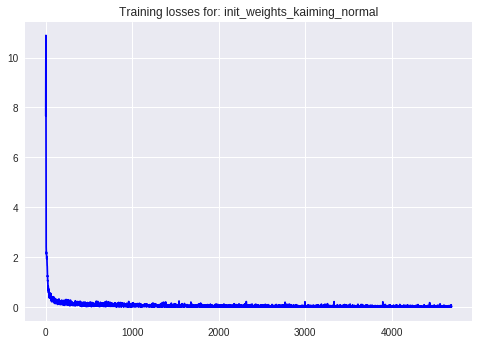

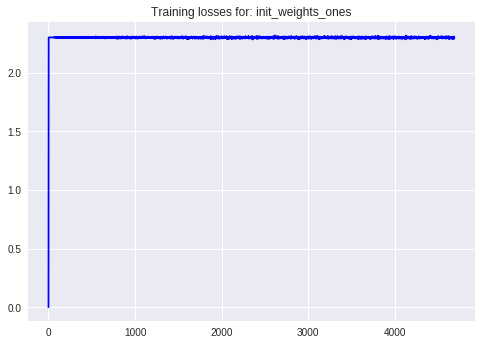

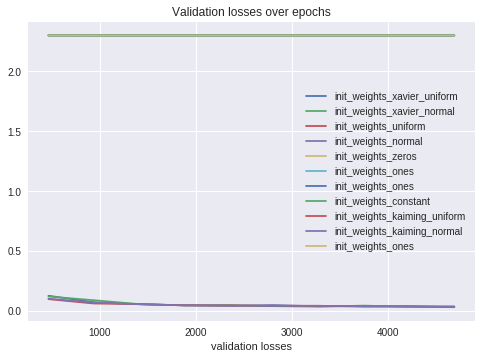

"\nplt.gcf().clear()\nplt.plot(train_losses, 'b-')\nplt.plot(valid_x, lossesTV[1], 'r-')\nplt.show()\n"

In [0]:
i = 0
j = 0

#This matrix(tensor) contain len(weight_init_dict) rows of num_epoch validation loss samples
#11x10
validation_losses_matrix = torch.Tensor(len(weight_init_dict),num_epochs)

for x in weight_init_dict:
  print("**************INITIALIZATION IS: " + weight_init_dict[x] + " **************")

  #Execute training and get a 3 element tuple
  lossesTV = train_with_init(x)
  
  train_losses = lossesTV[0]
  valid_losses = lossesTV[1]
  valid_x = lossesTV[2]
  
  #We need to assign a tensor of length [1][10] to another tensor of length [10]
  #Fixed with tensor.view()
  validation_losses_matrix[i,:] = torch.FloatTensor(valid_losses).view(num_epochs)
  plt.figure(i)#Plot for training losses of each initialization
  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.title("Training losses for: " + weight_init_dict[x])
  
  i += 1
  

#One plot for all the validation losses
plt.figure(i)
for k in weight_init_dict:
  plt.plot(valid_x, validation_losses_matrix[j,:].view(num_epochs,1).numpy(), label=weight_init_dict[k])
  j += 1

plt.xlabel('epoch')
plt.xlabel('validation losses')
plt.title("Validation losses over epochs")
plt.legend()
plt.show()
  
  
"""
plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, lossesTV[1], 'r-')
plt.show()
"""
  


## Accuracy (at epoch 10)



*   Xavier Uniform 99%
*   Xavier Normal 99%
*   Uniform 11%
*   Normal 10%
*   Zeros 11%
*   Ones 11%
*   Constant 11%
*   Kaiming Uniform 99%
*   Kaiming Normal 99%












## Zoom in
Some of the initializations have made the model diverge. Let's get a clearer comparison of the models which do diverge.

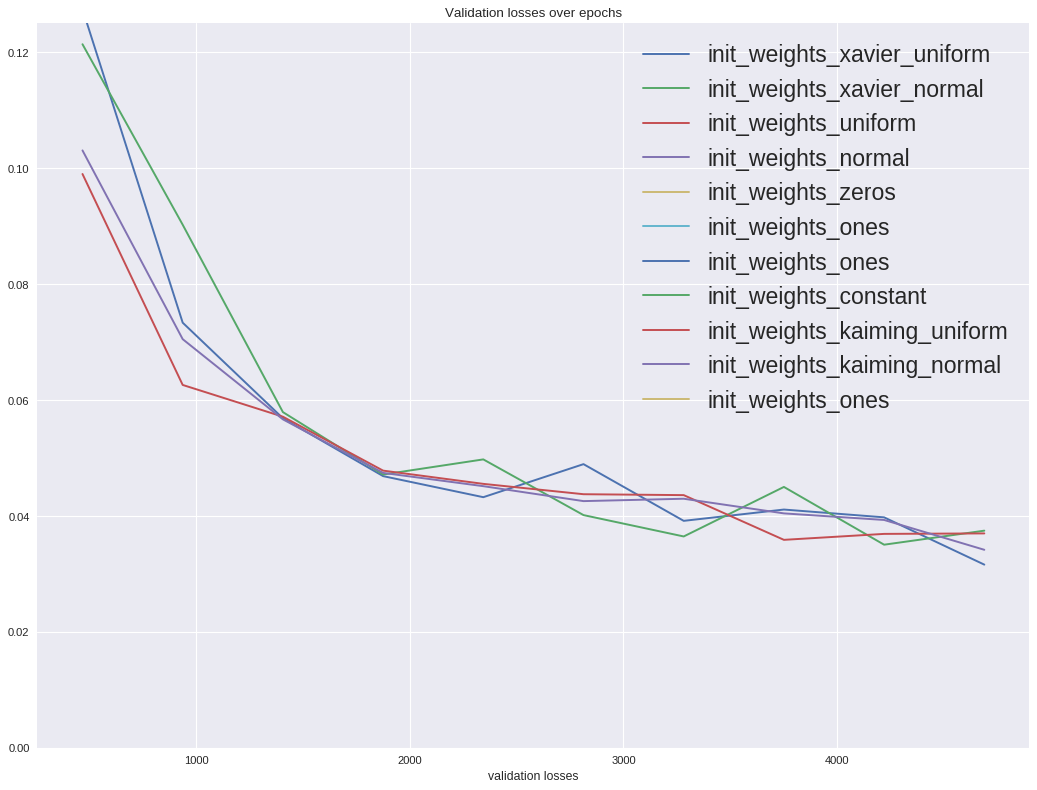

In [0]:
j=0
plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')#One for all the validation losses
for k in weight_init_dict:
  plt.plot(valid_x, validation_losses_matrix[j,:].view(num_epochs,1).numpy(), label=weight_init_dict[k])
  j += 1

plt.xlabel('epoch')
plt.xlabel('validation losses')
plt.title("Validation losses over epochs")
plt.ylim(0,0.125)#Limit the 'y' axis range
plt.legend(fontsize='xx-large')
plt.show()


Just to sum up a few things, first of all as we can see the initializations at zero are really bad. Zero is a critical point and signal will not propagate. 
Constant values are also a bad idea , it is need to break symmetry.
The good initializations are using small values, like a zero mean Gaussian probabilty distribution or some low range uniform random variable centered at zero.
We can see here that the bests initializations are Kaiming (uniform and normal) and Xavier (uniform and normal).
As we know the inputs to activation functions has to be in the linear area to allow gradients propagate and converge faster, for this reason values like one doesen't work so much well.
For example here we can see Xavier Normal Distribution that fits really well this feature.

![alt text](https://mnsgrg.com/assets/sigmoid.png)


Train Epoch: 1 [0/60000 (0%)]	Loss: 21.221479
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.414650
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.397846
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.148642
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.214310
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.172997

Validation set: Average loss: 0.1369, Accuracy: 9551/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.211484
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.147872
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.128899
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.131739
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.021963
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.114383

Validation set: Average loss: 0.1003, Accuracy: 9681/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.103655
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.065880
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.090885
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.093864
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.124784
Train Epoch: 3 [51200/60000 (8

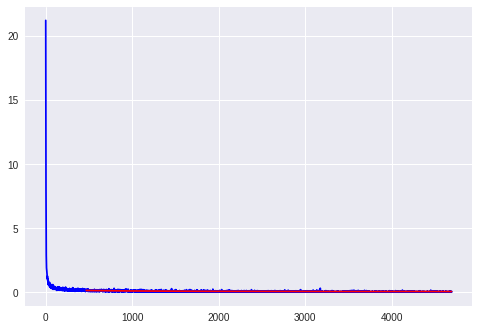

In [0]:
def init_weights_uniform(m):
  if type(m) == nn.Linear:
    nn.init.uniform_(m.weight, -0.2, 0.2)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.uniform_(m.weight, -0.2, 0.2)
    m.bias.data.fill_(0.01)
    
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
model.apply(init_weights_uniform)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()

Here we just want to show that if we change the range of the uniform distribution (putting some small range centered at 0) results are improving.

Accuracy: 98%

Train Epoch: 1 [0/60000 (0%)]	Loss: 124.167107
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.465904
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.250428
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.335879
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.901413
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.733232

Validation set: Average loss: 1.6368, Accuracy: 4874/10000 (49%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.683578
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.621995
Train Epoch: 2 [20480/60000 (34%)]	Loss: 1.087037
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.836285
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.813848
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.698246

Validation set: Average loss: 0.5048, Accuracy: 8597/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.563747
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.578765
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.408865
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.318887
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.493419
Train Epoch: 3 [51200/60000 (

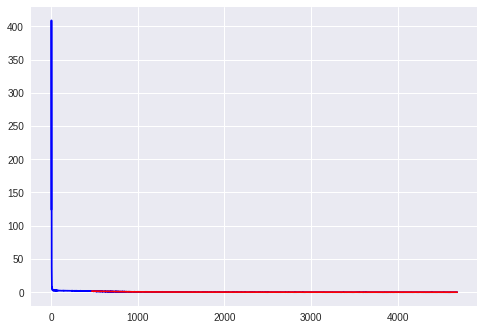

In [0]:
def init_weights_normal(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, 0, 0.2)
    #nn.init.xavier_uniform_(m.bias)
    m.bias.data.fill_(0.01)
  elif type(m) == nn.Conv2d:
    nn.init.normal_(m.weight, 0, 0.2)
    m.bias.data.fill_(0.01)

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
model.apply(init_weights_normal)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
valid_losses = []
valid_x = []
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
    train_losses.extend(epoch_losses)
    valid_loss = validate(model, device, valid_loader)
    valid_losses.append([valid_loss])
    valid_x.append(len(train_losses) - 1)

plt.gcf().clear()
plt.plot(train_losses, 'b-')
plt.plot(valid_x, valid_losses, 'r-')
plt.show()

Same as here, we have changed the variance of the gaussian regarding that is with a big range of numbers the results are bad, reducing de variance we can get better results.

**Accuracy**: 97%

# Testing Batch Size

## Function to train over an epoch

To test the batch size, we are going to use the same train function that we already used before.

## Function to evaluate performance

We have modified the validate() function in order to return the accuracy of the network while changing the batch size. 


In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return 100. * correct / len(loader.dataset)

## Iterating through the batch sizes
In order to test the batch sizes, we use an **exponential distribution** to test this values and we train the network for each batch size. Furthermore, another important parameter to take in account is the **training time**, i.e. the time that takes to train and test the network for a given batch size. Basically, the point is that exists a compromise between training time and accuracy, which can be seen in the charts:

In [0]:
transcurred_time = []
index = 0;
batch_sizes = [1<<exponent for exponent in range(1,9)]

for train_batch_size in batch_sizes:
      
  print ("\nCurrent batch size = " + str(train_batch_size) + "\n" )
  
  start_time = time.time()  
  
  mnist_mean = 0.1307
  mnist_stddev = 0.3081
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=True,
                     download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((mnist_mean,), (mnist_stddev,))
                     ])),
      batch_size=train_batch_size,
      shuffle=True)

  valid_batch_size = train_batch_size
  valid_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=False,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((mnist_mean,), (mnist_stddev,))
                     ])),
      batch_size=valid_batch_size,
      shuffle=True)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  train_losses = []
  valid_losses = []  
  valid_x = []
  valid_accuracy = []  
  num_epochs = 10
  epochs = [epoch for epoch in range(1,num_epochs+1)]
  
  for epoch in range(1, num_epochs + 1):
        epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
        train_losses.extend(epoch_losses)
        valid_acc = validate(model, device, valid_loader)
        valid_accuracy.append([valid_acc])
        valid_x.append(len(train_losses) - 1)
        
  plt.plot(epochs, valid_accuracy, label = 'Batch Size = ' + str(train_batch_size))     
  transcurred_time.append(time.time() - start_time)
  print("Duration of training for batch size of " + str(batch_sizes[index-1])+ " = " + str(transcurred_time[index-1]))
  index += 1
     
plt.legend()
plt.xlabel('Epochs')    
plt.ylabel('Accuracy (Validation)')    
plt.show()

plt.gcf().clear()
plt.plot(batch_sizes, transcurred_time, 'r-')
plt.xlabel('Batch Size')    
plt.ylabel('Transcurred time')    
plt.show()

## Graphical results

In [this slide](https://docs.google.com/presentation/d/1CHQazrf2W2SLbp7ccAElvUz_8xsrsHgfF3n-G2EVEf0/edit?usp=sharing), we present the graphical results of the experiment.




# Conclusions

**Batch Size:**

Despite the training time for batch sizes larger than 200 is quite low, the model is not very accurate and may not generalize unseen data well.
For batch sizes lower than 100, the training takes too much time and the accuracy level is similar than higher values.
So, as can be seen in the charts, the optimal batch size is between 100 and 200.


**Initializations:**

Initialize at constant values it's worng, the behaviour of the neural network is really bad and it does not learn. We could see that when we were taking a hudge range of valours with the uniform distribution we were taking bad results as well normal distribution with default variance and mean. But we can conclude that the best initializations in terms of loss are the Xavier and the Kaiming ones. 

# References

Nocedal, J., Keskar, N., Tang, P., Mudigere, D., Smelyanskiy, M., (2017). On large-batch training for Deep Learning: Generalization Gap and Sharp Minima. ICLR : https://arxiv.org/pdf/1609.04836.pdf 

Torch Contributors (2018) Source code for torch.nn.init: https://pytorch.org/docs/stable/_modules/torch/nn/init.html

cs231n CS231n Convolutional Neural Networks for Visual Recognition:   http://cs231n.github.io/neural-networks-2/#init